In [794]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import export_text
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

# Connect and drop the first row of each dataFrame 

In [795]:
con = sqlite3.connect("Dataset/database.db")

awards_players_df = pd.read_sql_query("SELECT * FROM awards_players", con)
coaches_df = pd.read_sql_query("SELECT * FROM coaches", con)
players_teams_df = pd.read_sql_query("SELECT * FROM players_teams", con)
players_df = pd.read_sql_query("SELECT * FROM players", con)
series_post_df = pd.read_sql_query("SELECT * FROM series_post", con)
teams_df = pd.read_sql_query("SELECT * FROM teams", con)

awards_players_df = awards_players_df.tail(-1)
coaches_df = coaches_df.tail(-1)
players_teams_df = players_teams_df.tail(-1)
players_df = players_df.tail(-1)
series_post_df = series_post_df.tail(-1)
teams_df = teams_df.tail(-1)

In [796]:
playoffs_balance = teams_df['playoff'].value_counts()

print(playoffs_balance)

Y    80
N    62
Name: playoff, dtype: int64


The dataset is not perfectly balanced, but it is relatively close. It's generally desirable to have a balanced dataset, but slight imbalances like this may not pose a significant issue for many classification tasks.

# Clean the dataset

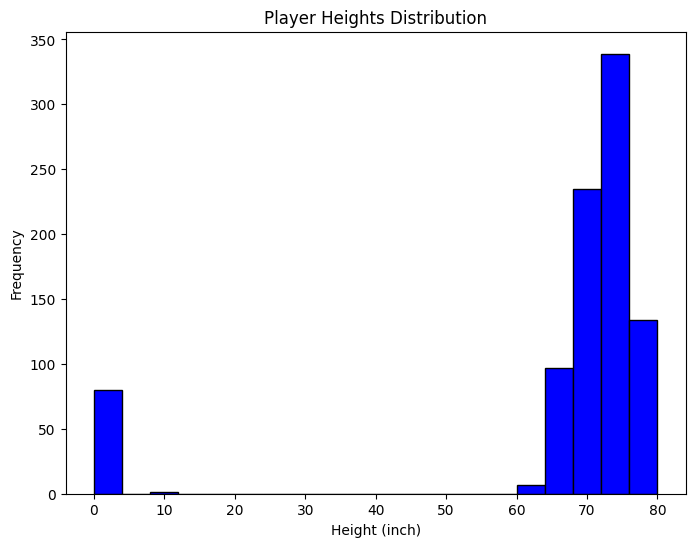

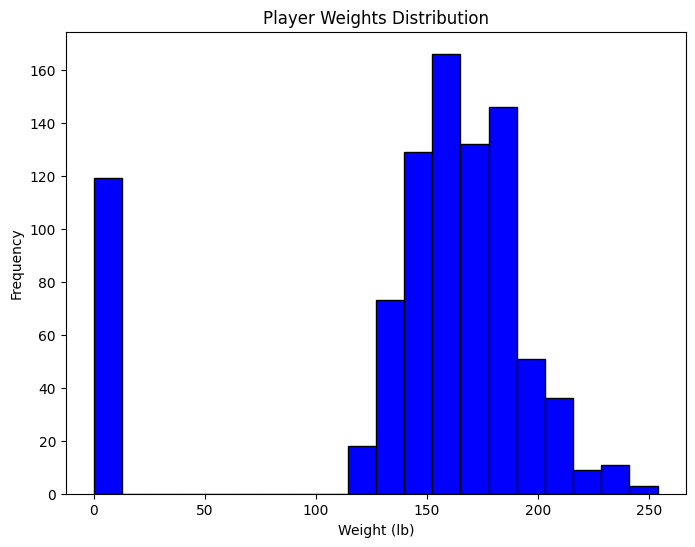

In [797]:
teams_df.dropna(inplace=True)
coaches_df.dropna(inplace=True)
players_df.dropna(inplace=True)
series_post_df.dropna(inplace=True)
players_teams_df.dropna(inplace=True)
awards_players_df.dropna(inplace=True)

plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Height (inch)')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

In [798]:
# Merge the 'players' and 'players_teams' DataFrames on the 'bioID' and 'playerID' columns, respectively
merged_data = players_df.merge(players_teams_df, left_on='bioId', right_on='playerID')

# Filter for rows where 'height' is equal to 0
result = merged_data[merged_data['height'] == 0]

print(result)



Empty DataFrame
Columns: [bioId, pos, firstseason, lastseason, height, weight, college, collegeOther, birthDate, deathDate, playerID, year, stint, tmID, lgID, GP, GS, minutes, points, oRebounds, dRebounds, rebounds, assists, steals, blocks, turnovers, PF, fAttempted, fgMade, ftattempted, ftMade, threeAttempted, threeMade, dq, PostGP, PostGS, PostMinutes, PostPoints, PostoRebounds, PostdRebounds, PostRebounds, PostAssists, PostSteals, PostBlocks, PostTurnovers, PostPF, PostfgAttempted, PostfgMade, PostftAttempted, PostftMade, PostthreeAttempted, PostthreeMade, PostDQ]
Index: []

[0 rows x 53 columns]


Since the players that have 0inches have all the other information as 0's and either are coaches or don't beleng to any team, we will drop them from the dataset.

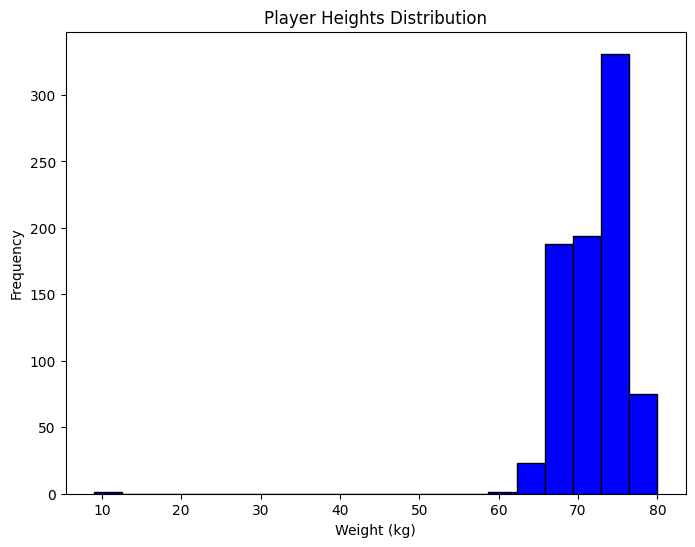

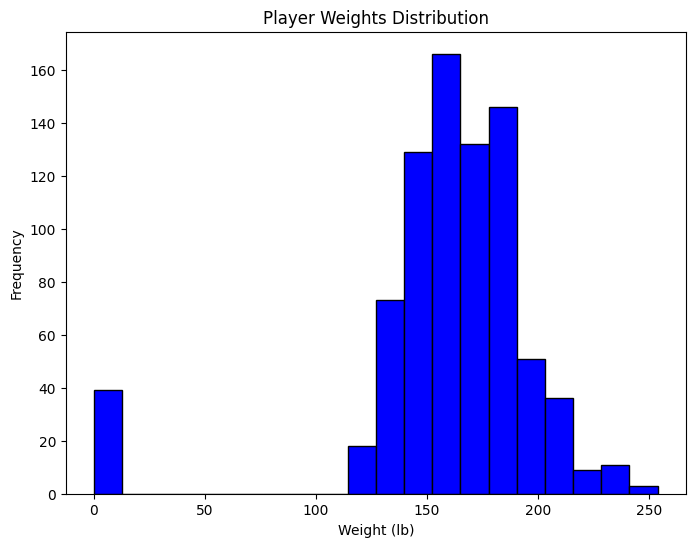

In [799]:
players_df = players_df[players_df['height'] > 0]
plt.figure(figsize=(8, 6))
plt.hist(players_df['height'], bins=20, color='blue', edgecolor='black')
plt.title('Player Heights Distribution')
plt.xlabel('Weight (kg)')
plt.ylabel('Frequency')
plt.show()


plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

As can be seen, even after taking out the players that have height as 0 and all the other columns as 0, there are still some players that have the weight as 0. To address this, we opted to replace the 0 value by the average weight of the players that have the same position

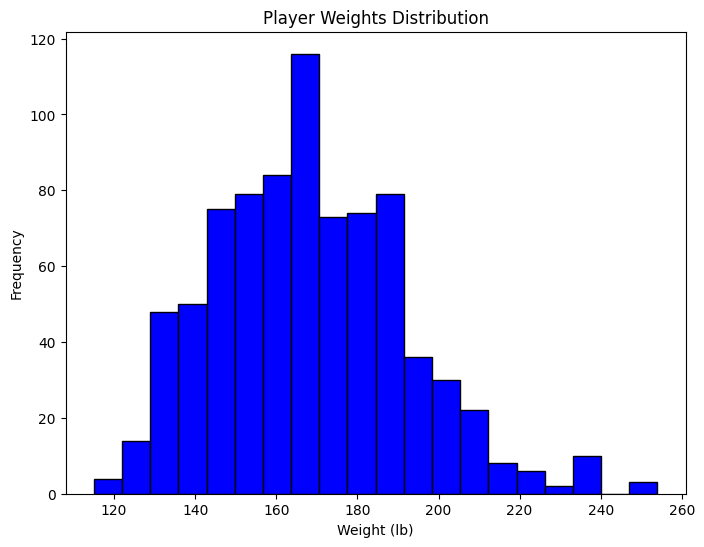

In [800]:
avg_weight_by_position = players_df[players_df['weight'] > 0].groupby('pos')['weight'].mean().reset_index()
avg_weight_by_position.rename(columns={'weight': 'avg_weight'}, inplace=True)

avg_weight_by_position['avg_weight'] = avg_weight_by_position['avg_weight'].round(2)

players_df = players_df.merge(avg_weight_by_position, on='pos', how='left')


players_df.loc[players_df['weight'] == 0, "weight"] = players_df['avg_weight']



plt.figure(figsize=(8, 6))
plt.hist(players_df['weight'], bins=20, color='blue', edgecolor='black')
plt.title('Player Weights Distribution')
plt.xlabel('Weight (lb)')
plt.ylabel('Frequency')
plt.show()

players_df.drop('avg_weight', axis=1, inplace=True)


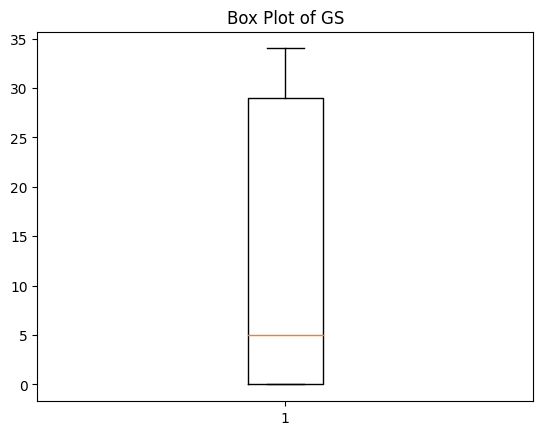

In [801]:
plt.boxplot(players_teams_df['GS'])
plt.title('Box Plot of GS')
plt.show()

In [802]:
# Check for missing values
awards_players_missing = awards_players_df.isnull().sum()

coaches_missing = coaches_df.isnull().sum()

players_teams_missing = players_teams_df.isnull().sum()

players_missing = players_df.isnull().sum()

series_post_missing = series_post_df.isnull().sum()

teams_missing = teams_df.isnull().sum()

# Print the results for each DataFrame
print("Missing values in awards_players_df:")
print(awards_players_missing)

print("Missing values in coaches_df:")
print(coaches_missing)

print("Missing values in players_teams_df:")
print(players_teams_missing)

print("Missing values in players_df:")
print(players_missing)

print("Missing values in series_post_df:")
print(series_post_missing)

print("Missing values in teams_df:")
print(teams_missing)

Missing values in awards_players_df:
playerID    0
award       0
year        0
lgID        0
dtype: int64
Missing values in coaches_df:
coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64
Missing values in players_teams_df:
playerID              0
year                  0
stint                 0
tmID                  0
lgID                  0
GP                    0
GS                    0
minutes               0
points                0
oRebounds             0
dRebounds             0
rebounds              0
assists               0
steals                0
blocks                0
turnovers             0
PF                    0
fAttempted            0
fgMade                0
ftattempted           0
ftMade                0
threeAttempted        0
threeMade             0
dq                    0
PostGP                0
PostGS                0
PostMinutes           0
PostPoints    

As can be seen in the output of the last cell, the dataset has no missing values so there's no need to replace any of them.

In [803]:
columns_to_drop = players_teams_df.filter(like='Post', axis=1).columns
players_teams_df = players_teams_df.drop(columns=columns_to_drop)
players_teams_df = players_teams_df.drop(columns=['lgID', 'stint'])

players_teams_df.head()


,playerID,year,tmID,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,MIN,26,23,846,343,43,131,174,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,MIN,27,27,805,314,45,101,146,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,MIN,30,25,792,318,44,97,141,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,MIN,22,11,462,146,17,57,74,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,MIN,31,31,777,304,29,78,107,...,6,80,86,276,109,73,53,82,33,0


Since we only want to know which teams are more likely to get to the playoffs, there is no need in having the information associated to the playoffs of the previous seasons. Therefore, the columns that contain this information will be dropped.

In [804]:
duplicate_records = players_teams_df.duplicated(keep='first')

# Original DataFrame shape (before removing duplicates)
original_shape = players_teams_df.shape

# Shape of the DataFrame after removing duplicates
new_shape = duplicate_records.shape

# Calculate the number of duplicates dropped
duplicates_dropped = original_shape[0] - new_shape[0]

# Print the number of duplicates dropped
print(f"Number of duplicates dropped: {duplicates_dropped}")


illogical_records = players_teams_df[players_teams_df['GS'] > players_teams_df['GP']]
illogical_count = len(illogical_records)

print(f"Number of illogical values: {illogical_count}")

Number of duplicates dropped: 0
Number of illogical values: 0


In [805]:
zero_gp_count = players_teams_df[players_teams_df['minutes'] == 0].groupby('year')['playerID'].count()

print(zero_gp_count)

players_teams_df.head()

year
9    3
Name: playerID, dtype: int64


,playerID,year,tmID,GP,GS,minutes,points,oRebounds,dRebounds,rebounds,...,blocks,turnovers,PF,fAttempted,fgMade,ftattempted,ftMade,threeAttempted,threeMade,dq
1,abrossv01w,2,MIN,26,23,846,343,43,131,174,...,9,85,70,293,114,132,96,76,19,2
2,abrossv01w,3,MIN,27,27,805,314,45,101,146,...,10,92,73,316,119,116,56,60,20,0
3,abrossv01w,4,MIN,30,25,792,318,44,97,141,...,11,90,79,285,112,98,69,82,25,0
4,abrossv01w,5,MIN,22,11,462,146,17,57,74,...,2,43,42,139,49,46,28,53,20,0
5,abrossv01w,6,MIN,31,31,777,304,29,78,107,...,6,80,86,276,109,73,53,82,33,0


In [806]:
awards_coaches_df = awards_players_df[awards_players_df["award"] == "Coach of the Year"]
awards_coaches_df.head()

,playerID,award,year,lgID
9,coopemi01w,Coach of the Year,1,WNBA
10,hugheda99w,Coach of the Year,2,WNBA
11,stanlma99w,Coach of the Year,3,WNBA
12,laimbbi01w,Coach of the Year,4,WNBA
13,mcconsu01w,Coach of the Year,5,WNBA


In [807]:
teams_df_clean = teams_df[['year', 'tmID', 'confID', 'attend', 'playoff']]
players_df = players_df.drop(columns = ['lastseason', 'firstseason', 'deathDate', 'college', 'collegeOther'])

# Define the years for the training and testing sets
training_years = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize an empty DataFrame to store the testing set with the last 2 years' statistics
testing_set_with_stats = pd.DataFrame()

players_df = players_df.rename(columns={'bioId': 'playerID'})



for year in training_years:

    players_in_year = players_teams_df[players_teams_df['year'] == year]

    last_2_years_stats = players_teams_df[players_teams_df['year'].isin([year - 1, year - 2])]

    last_2_years_stats = last_2_years_stats[last_2_years_stats['playerID'].isin(players_in_year['playerID'])]

    # Group the data by playerID and calculate the mean statistics for the last 2 years
    last_2_years_means = last_2_years_stats.groupby('playerID').mean().reset_index()

    # Merge 'last_2_years_means' with 'players_df' based on the 'playerID' column
    testing_set_for_year = last_2_years_means.merge(players_df, on='playerID', how='left')

    # Add a 'year' column to indicate the year for which this data is used
    testing_set_for_year['year'] = year

    # Append the data for this year to the testing set DataFrame
    testing_set_with_stats = testing_set_with_stats.append(testing_set_for_year, ignore_index=True)



players_teams_df= players_teams_df[['playerID', 'year', 'tmID']]



testing_set_with_stats = testing_set_with_stats.merge(players_teams_df, on=['playerID', 'year'], how='left')



# Group the DataFrame by 'tmID' and 'year', and calculate the average for each group
team_year_averages = testing_set_with_stats.groupby(['tmID', 'year']).mean().reset_index()



for index, row in coaches_df.iterrows():
    year = row['year']
    tmID = row['tmID']
    coachID = row['coachID']
    won = row['won']
    lost = row['lost']

    relevant_rows = coaches_df[
        (coaches_df['coachID'] == coachID) &
        (coaches_df['year'] >= year - 2) &  # Filter for the previous 2 years
        (coaches_df['year'] < year)  # Exclude the current year
    ]

    coach_wins = relevant_rows['won'].sum()
    coach_losses = relevant_rows['lost'].sum()

    matching_row = team_year_averages[
        (team_year_averages['year'] == year) &
        (team_year_averages['tmID'] == tmID)
    ]

    if not matching_row.empty:
        team_year_averages.loc[matching_row.index, 'coachID'] = coachID
        team_year_averages.loc[matching_row.index, 'coachWins'] = coach_wins
        team_year_averages.loc[matching_row.index, 'coachLosses'] = coach_losses


teams_df_clean = teams_df_clean.merge(team_year_averages, on = ['year', 'tmID'], how ='left')

teams_df_clean = teams_df_clean[teams_df_clean['year'] != 1]

# Specify the file path where you want to save the CSV file
file_path = "testing_set_with_stats.csv"

# Use the to_csv method to export the DataFrame to a CSV file
teams_df_clean.to_csv(file_path, index=False)




/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_3318/196638093.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  last_2_years_means = last_2_years_stats.groupby('playerID').mean().reset_index()
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_3318/196638093.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  testing_set_with_stats = testing_set_with_stats.append(testing_set_for_year, ignore_index=True)
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_3318/196638093.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which sho

In [808]:
awards_players_df = awards_players_df.rename(columns={'Kim Perrot Sportsmanship': 'Kim Perrot Sportsmanship Award'})


award_points = {
    "Most Valuable Player": 10,
    "Rookie of the Year": 9,
    "Defensive Player of the Year": 8,
    "WNBA Finals Most Valuable Player": 7,
    "Most Improved Player": 6,
    "Sixth Woman of the Year": 5,
    "Kim Perrot Sportsmanship Award": 4,
    "All-Star Game Most Valuable Player": 3,
}

relevant_awards = awards_players_df[awards_players_df['award'].isin(award_points.keys())]

awards_players_teams = relevant_awards.merge(players_teams_df, on=['playerID', 'year'], how='left')

awards_players_teams['award_points'] = awards_players_teams['award'].map(award_points)

years_of_interest = [2,3,4,5,6,7,8,9,10] 

# Initialize an empty DataFrame to store the results
player_award_points = pd.DataFrame()


for year in years_of_interest: 

    previous_2_years_awards = awards_players_teams[awards_players_teams['year'].isin([year - 1, year - 2])]

    player_yearly_award_points = previous_2_years_awards.groupby(['playerID'])['award_points'].sum().reset_index()

    player_yearly_award_points['year'] = year

    player_award_points = player_award_points.append(player_yearly_award_points, ignore_index=True)

player_award_points = player_award_points.merge(players_teams_df, on=['playerID', 'year'], how='left')

player_award_points = player_award_points.dropna(subset=['tmID'])

player_award_points = player_award_points.groupby(['tmID', 'year']).sum().reset_index()


teams_df_clean = teams_df_clean.merge(player_award_points, on = ['year', 'tmID'], how ='left')

teams_df_clean['award_points'].fillna(0, inplace=True)

teams_df_clean.to_csv("awards.csv", index=False)


# # Loop through the years of interest to calculate award points for each player
# for year in years_of_interest:
#     # Step 1: Filter awards data for the previous 2 years for the current year
#     previous_2_years_awards = awards_players_teams[(awards_players_teams['year'] >= year - 2) & (awards_players_teams['year'] < year)]
#     previous_2_years_awards.to_csv("awards.csv", index=False)´

#     # Step 2: Group the data by 'playerID' and year and sum the award points
#     player_yearly_award_points = previous_2_years_awards.groupby(['playerID', 'year'])['award_points'].sum().reset_index()

#     # Step 3: Append the results to the DataFrame
#     player_award_points = player_award_points.append(player_yearly_award_points, ignore_index=True)

# #player_award_points.to_csv("awards.csv", index=False)

/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_3318/3739012017.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_award_points = player_award_points.append(player_yearly_award_points, ignore_index=True)
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_3318/3739012017.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_award_points = player_award_points.append(player_yearly_award_points, ignore_index=True)
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_3318/3739012017.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  player_award_points = player_award_points.append(player_yearly_award_points, ignore_index=True)
/var/folders/74/sn0cqgq51dq1qw64s8fbvh2w0000gn/T/ipykernel_33

In [809]:
teams_df_clean = pd.get_dummies(teams_df_clean, columns=['tmID', 'confID', 'coachID'])

In [810]:
training_set = teams_df_clean[teams_df_clean['year'] <= 9]

# Filter the testing set (year 10)
testing_set = teams_df_clean[teams_df_clean['year'] == 10]

logistic_regression = LogisticRegression(solver='liblinear')

features = training_set.drop(columns = "playoff")
target = training_set['playoff']

logistic_regression.fit(features, target)

test_features = training_set.drop(columns = "playoff")  # Replace with your testing features
predictions = logistic_regression.predict(test_features)

test_target = training_set['playoff']


accuracy = accuracy_score(test_target, predictions)
classification_rep = classification_report(test_target, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(classification_rep)

Accuracy: 0.73
              precision    recall  f1-score   support

           N       0.73      0.61      0.67        49
           Y       0.74      0.83      0.78        64

    accuracy                           0.73       113
   macro avg       0.73      0.72      0.72       113
weighted avg       0.73      0.73      0.73       113



In [811]:
knn_classifier = KNeighborsClassifier(n_neighbors=3)

knn_classifier.fit(features, target)

predictions = knn_classifier.predict(test_features)

accuracy = accuracy_score(test_target, predictions)
classification_rep = classification_report(test_target, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(classification_rep)

Accuracy: 0.77
              precision    recall  f1-score   support

           N       0.73      0.73      0.73        49
           Y       0.80      0.80      0.80        64

    accuracy                           0.77       113
   macro avg       0.77      0.77      0.77       113
weighted avg       0.77      0.77      0.77       113



Accuracy: 1.00
              precision    recall  f1-score   support

           N       1.00      1.00      1.00        49
           Y       1.00      1.00      1.00        64

    accuracy                           1.00       113
   macro avg       1.00      1.00      1.00       113
weighted avg       1.00      1.00      1.00       113



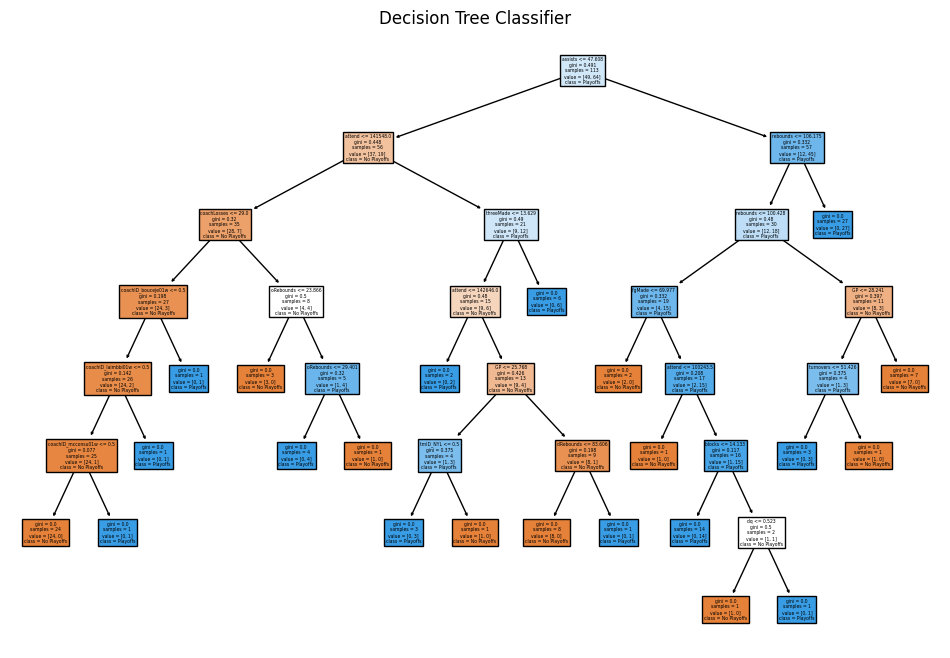

In [812]:
decision_tree_classifier = DecisionTreeClassifier(random_state=41)

decision_tree_classifier.fit(features, target)

predictions = decision_tree_classifier.predict(test_features)

accuracy = accuracy_score(test_target, predictions)
classification_rep = classification_report(test_target, predictions)

print(f'Accuracy: {accuracy:.2f}')
print(classification_rep)

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(decision_tree_classifier, filled=True, feature_names=features.columns, class_names=["No Playoffs", "Playoffs"])
plt.title("Decision Tree Classifier")
plt.show()